#
# Deep Learning
## Project: Building a German Traffic Sign Recognition Classifier

### Step 1: Load data provided as a pickle.

In [1]:
#Vijay D, Udacity CarND-Term1, Project 2: Traffic Sign Classifer

# Load training, validation and test data (pickled data)
import pickle
from itertools import *
import numpy as np
import matplotlib.gridspec as gridspec

training_file = 'data/train.p'
validation_file='data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
unique_classes =  len(np.unique(y_train))
unique_labels  =  np.unique(y_train)

print('Total training examples   = ', len(X_train) )
print('Total validation examples = ', len(X_valid) )
print('Total testing examples    = ', len(X_test) )
print('Shape of the image arrays = ', X_train.shape)
print("# of unique classes       = ", unique_classes)
#print ('y_train', type(y_train))
#print ('y_train shape', y_train.shape)
#print ('X_train', type(X_train))


Total training examples   =  34799
Total validation examples =  4410
Total testing examples    =  12630
Shape of the image arrays =  (34799, 32, 32, 3)
# of unique classes       =  43


### Step 2: Dataset Summary & Exploration

#The pickled data is a dictionary with 4 key/value pairs:
#'features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
#'labels' is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
#'sizes' is a list containing tuples, (width, height) representing the original width and height the image.
#'coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. #THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES
#### Visualize the type of images the dataset contains; displaying a random image below.

Random Sampling of Images from Dataset


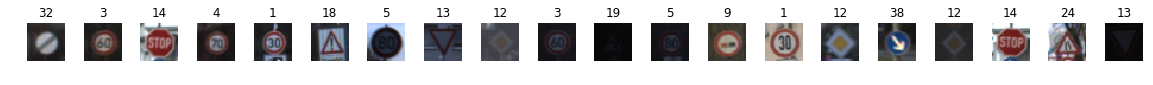

In [2]:
#Visualize Data
#View a sample from the dataset.

import random
import matplotlib.pyplot as plt
%matplotlib inline

#train_images, train_labels = X_train, y_train
#h = np.histogram(train_labels, bins=np.arange(unique_classes))
#print (h[0], h[1])

#Sampling of images contained in the dataset
#for i in range(10):
#    index = random.randint(0, len(X_train))
#    image = X_train[index].squeeze()
#    plt.figure(figsize=(2,2))
#    plt.imshow(image)
#    plt.title(y_train[index])
    #print(image.shape)

numrows = 2
numfigs = 20

fig = plt.figure(figsize=(numfigs,numrows))
gs1 = gridspec.GridSpec(numrows,numfigs)
gs1.update(wspace=0.5, hspace=0.5) # set the spacing between axes. 

for j in range(numfigs):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    ax = plt.subplot(gs1[j])
    plt.imshow(image)
    plt.title(y_train[index])
    plt.axis("off")
    #ax = plt.subplot(gs1[numfigs+j])
    
#Print sample augmented images for the first unique label/class
print('Random Sampling of Images from Dataset')
    
    
#train_images, train_labels = X_train, y_train
#h = np.histogram(train_labels, bins=np.arange(unique_classes))


#### Check whether data is approx. equally distributed (NOT)

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210] 1890


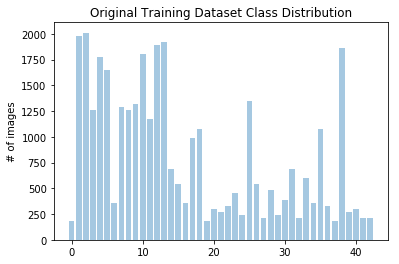

Image Class Distribution 
	Mean 			=  809.28 
	Standard Deviation 	=  619.42


In [3]:
#Plotting number of samples against classes
counts = []
for i in range(unique_classes):
    counts.append(np.sum(y_train == i))
print (counts, counts[12])

plt.bar(range(len(counts)), counts, align='center', alpha=0.4)
plt.title('Original Training Dataset Class Distribution')
plt.ylabel('# of images')
plt.show()

mu = np.mean(counts)
sigma = np.std(counts, dtype=np.float64)
print ('Image Class Distribution \n\tMean \t\t\t=  {:.2f}'.format(mu), '\n\tStandard Deviation \t=  {:.2f}'.format(sigma ))

###### Uneven distribution of classwise images can be seen from the above histogram. So, class data have to be equalized. The method adopted for that here is to simply augment data (more on that below) equally for each class. So, the total required images for each class is set to the maximum (among the class counts). The actual generation for each class will be: (max(class count) – count[class])

### Step 3: Data Augmentation and preprocessing
#### Some data augmentation done here...thru brightness adjustment, rotation, translation and flipping of certain classes that allow, as noted below. Augmentation code is used from existing public github repos; each is noted below.

##### First, flipping of images about the horizontal or vertical axis.

In [4]:
import cv2

# Code from Alex @ navoshta.com
def flip_extend(X, y):
    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    # Classes of signs that, when flipped vertically, should still be classified as the same class
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    # Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
    self_flippable_both = np.array([32, 40])
    # Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
    cross_flippable = np.array([
        [19, 20], 
        [33, 34], 
        [36, 37], 
        [38, 39],
        [20, 19], 
        [34, 33], 
        [37, 36], 
        [39, 38],   
    ])
    num_classes = 43
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    
    for c in range(num_classes):
        # First copy existing data for this class
        X_extended = np.append(X_extended, X[y == c], axis = 0)
        # If we can flip images of this class horizontally and they would still belong to said class...
        if c in self_flippable_horizontally:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis = 0)
        # If we can flip images of this class horizontally and they would belong to other class...
        if c in cross_flippable[:, 0]:
            # ...Copy flipped images of that other class to the extended array.
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class vertically and they would still belong to said class...
        if c in self_flippable_vertically:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class horizontally AND vertically and they would still belong to said class...
        if c in self_flippable_both:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
    
    return (X_extended, y_extended)

#### Next, augmentation from rotation, translation and brightness adjustment of original images. Below methods are a combination of OpenCV.org and Vivek Yadav

In [5]:
# a la Vivek Yadav and OpenCV.org
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = 0.25 + np.random.uniform()

    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1
	
	
# a la Vivek Yadav and OpenCV.org
def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.
    A Random uniform distribution is used to generate different parameters for transformation
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
      img = augment_brightness_camera_images(img)

    return img



In [6]:
def GetIndexof(lbl):
	for i in range(len(unique_labels)):
		if unique_labels[i] == lbl:
			return i


In [7]:
def preprocess(image_batch):
    
    global preprocessed
    
    preprocessed.append(image_batch[0].squeeze()) #Capture the before preproc image
    
    for eachimg in image_batch:
        #print (eachimg.shape)
        eachimg = cv2.cvtColor(eachimg, cv2.COLOR_RGB2GRAY)  #Convert to grayscale
        eachimg -= np.mean(eachimg) #Mean centering
        #eachimg = (eachimg-128.)/128.
       
    preprocessed.append(image_batch[0].squeeze()) #We capture the after preproc img
    return image_batch

#### Augmentation done here

In [8]:
#Taking stock one more time
print ('Original dataset length: ', len(X_train))
counts = []
for i in range(unique_classes):
    counts.append(np.sum(y_train == i))
print ('Max. count before augmentation: ', np.max(counts), 'counts[12]', counts[12])
#print (counts)


# Temp placeholder lists for holding augmented data
X = [] 
y = []
augmented_images = 0      # Num. of images augmented by rotation and translation.
maxcount = np.max(counts) # note the max. count for any class
num_augment = 2           # Number of times the dataset is augmented thru rot/translation/brightness adj; NOT FLIPPING
examples = []
unamas = 1
preprocessed = []  #To capture before and after images  - preprocessing 
#print ('unique_labels', unique_labels)

for label in unique_labels:

        label_index = GetIndexof(label)
        #print ('label, index, value of counts at index:', label, label_index, counts[label_index])
        for i in range(len(X_train[0])): #Locate first the img for a specific label
            if (y_train[i] == label):
                image = X_train[i].squeeze() # Call it image
                examples.append(image)       #Save original as part of examples

        #gs1 = gridspec.GridSpec(10, 10)
        #gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.

        
        #To equalize the distribution of classes approx., we will bring each class to a total of (maximum count from the prior distribution)
        images_needed = int(maxcount/3 - counts[label_index])
        #print ('Images needed for class', label, images_needed, "Currently: ", )
        if (images_needed > 0): #Augment only when a class is underrepresented
            augmented_images += images_needed
            print ('Generating ', images_needed, 'images for class ', label, 'currently: ', counts[label_index])
            for i in range(images_needed):
                img = transform_image(image,20,10,5,brightness=1)
                X.append(img)
                y.append(label)
                #print (len(X))
                if (unamas == 1 and len(examples) < 10 and i%10 == 0):
                    examples.append(img)
            unamas = 2
            images_needed = 0 #reset counter

#Converting lists to arrays
X_transrot = np.array(X, dtype=np.float32)
y_transrot = np.array(y, dtype=np.int32)
print ('Images augmented by rotation/translation/brighness adj.: ', augmented_images)

#DisplayGrid(X_tend)  -- not used 

#Augmented images are being appended to X_train, y_train
X_train = np.concatenate((X_train, X_transrot), axis=0)
y_train = np.concatenate((y_train, y_transrot), axis=0)

print ('Max. count before flipping: ', np.max(counts), 'counts[12]', counts[12])

#IMAGE FLIPPING

X_flip, y_flip = flip_extend(X_train, y_train)
print ("Images augmented by flipping: ", len(X_flip))

#Flipped images are being appended to X_train, y_train
X_train = np.concatenate((X_train, X_flip), axis=0)
y_train = np.concatenate((y_train, y_flip), axis=0)

print ('Images in dataset after augmentation: ', len(X_train))

#Shuffle unamas!
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)


Original dataset length:  34799
Max. count before augmentation:  2010 counts[12] 1890
Generating  490 images for class  0 currently:  180
Generating  310 images for class  6 currently:  360
Generating  130 images for class  15 currently:  540
Generating  310 images for class  16 currently:  360
Generating  490 images for class  19 currently:  180
Generating  370 images for class  20 currently:  300
Generating  400 images for class  21 currently:  270
Generating  340 images for class  22 currently:  330
Generating  220 images for class  23 currently:  450
Generating  430 images for class  24 currently:  240
Generating  130 images for class  26 currently:  540
Generating  460 images for class  27 currently:  210
Generating  190 images for class  28 currently:  480
Generating  430 images for class  29 currently:  240
Generating  280 images for class  30 currently:  390
Generating  460 images for class  32 currently:  210
Generating  71 images for class  33 currently:  599
Generating  310 

Sample Augmented Images (1st = Original)


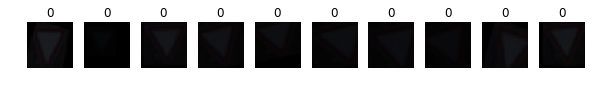

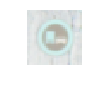

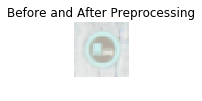

In [9]:

#Preprocess images
X_train = preprocess(X_train)

numrows = 2
numfigs = 10

fig = plt.figure(figsize=(numfigs,numrows))
gs1 = gridspec.GridSpec(numrows,numfigs)
gs1.update(wspace=0.25, hspace=0.25) # set the spacing between axes. 

for j in range(numfigs):
    ax = plt.subplot(gs1[j])
    plt.imshow(examples[j])
    plt.title(unique_labels[0])
    plt.axis("off")
    #ax = plt.subplot(gs1[numfigs+j])
    
#Print sample augmented images for the first unique label/class
print('Sample Augmented Images (1st = Original)')
   

for j in range(0,2):
    
    plt.figure(figsize=(1,1))
    plt.imshow(preprocessed[j])
    plt.axis("off")

plt.title('Before and After Preprocessing')    

############################END AUGMENTATION#########################################

#### Recheck total data for class distribution

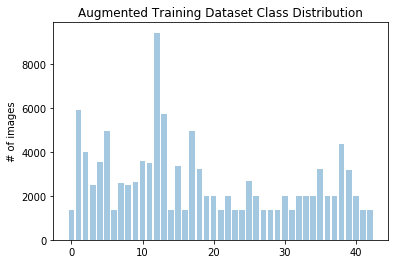

Image Class Distribution 
	Mean 			=  2690.93 
	Standard Deviation 	=  1619.08


In [10]:
counts1 = []
for i in range(len(unique_labels)):
    counts1.append(np.sum(y_train == i))
#print (counts1, counts1[0] )

plt.bar(range(len(counts1)), counts1, align='center', alpha=0.4)
plt.title('Augmented Training Dataset Class Distribution')
plt.ylabel('# of images')
plt.show()

#Find mean and std dev of the augmented dataset, it will still show some unevenness because the asymmetrical nature of augmenting via flipping
mu = np.mean(counts1)
sigma = np.std(counts1, dtype=np.float64)
print ('Image Class Distribution \n\tMean \t\t\t=  {:.2f}'.format(mu), '\n\tStandard Deviation \t=  {:.2f}'.format(sigma ))

#Shuffle unamas!
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)


##### The distribution, for the most part, looks ok. The sharp variation in some classes is due to the addition of images from the flipping operation.

### Step 4: Setup model architecture (based on LeNet(), with some additional layers (Conv, pooling, Dropouts))

In [11]:
from tensorflow.contrib.layers import flatten

def SimpLeNet(x):  
    
    global l2losses
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer in a very narrow range, eg, b/w 0.0 - 0.1
    mu = 0
    sigma = 0.1 
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_W = tf.multiply (conv1_W, tf.sqrt(2./3072.))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    l2losses += tf.nn.l2_loss(conv1_W)
    
         
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    #conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. input = 28x28x6, Output = 24x24x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    l2losses += tf.nn.l2_loss(conv2_W)
    
    # SOLUTION: Layer 3 (New): Convolutional. Input = 24x24x32. O/P = 20x20x64
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # SOLUTION: Activation for NL 1
    conv3 = tf.nn.relu(conv3)
    l2losses += tf.nn.l2_loss(conv3_W)
        
    # SOLUTION: Layer 4 (New) : Convolutional. Input = 20x20x64. O/P = 16x16x128
    conv4_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 64, 128), mean = mu, stddev = sigma))
    #conv3_W = tf.multiply (conv3_W, tf.sqrt(2./3200.))
    conv4_b = tf.Variable(tf.zeros(128))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b
    
    # SOLUTION: Activation for NL 1
    conv4 = tf.nn.relu(conv4)
    l2losses += tf.nn.l2_loss(conv4_W)
    
        
    # SOLUTION: Layer 5 (New): Convolutional. Input = 16x16x128. O/P = 12x12x128
    conv5_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 128, 128), mean = mu, stddev = sigma))
    conv5_b = tf.Variable(tf.zeros(128))
    conv5   = tf.nn.conv2d(conv4, conv5_W, strides=[1, 1, 1, 1], padding='VALID') + conv5_b
    
    # SOLUTION: Activation for NL 1
    conv5 = tf.nn.relu(conv5)
    l2losses += tf.nn.l2_loss(conv5_W)
    
    # SOLUTION: Pooling. Input = 12x12x128. Output = 6x6x128
    conv5 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
       
    # SOLUTION: Flatten. Input = 6x6x128. Output = 4608
    fc0   = flatten(conv5)
    
    
    #Adding a new dropout 
    fc0    = tf.nn.dropout(fc0, 0.5)
    
    # SOLUTION: Fully Connected 1 . Input = 4608. Output = 2000.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(4608, 2000), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(2000))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
        
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    #l2losses += tf.nn.l2_loss(fc1_W)

    #Adding a new dropout 
    fc1    = tf.nn.dropout(fc1, 0.5)
        
    # SOLUTION: Fully Connected 2. Input = 2000. Output = 120.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(2000, 120), mean = mu, stddev = sigma))
    #fc2_W = tf.multiply (fc2_W, tf.sqrt(2./120.))
    fc2_b  = tf.Variable(tf.zeros(120))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    #l2losses += tf.nn.l2_loss(fc2_W)

    #Adding a new dropout layer 2
    fc2    = tf.nn.dropout(fc2, 0.5)
    
    # SOLUTION:Fully Connected 3. Input = 120. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma)) 
    #fc3_W = tf.multiply (fc3_W, tf.sqrt(2./43.))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    #l2losses += tf.nn.l2_loss(fc3_W)
    
    return logits



### Step 5: Train, Validate and Test the Model

In [12]:
import tensorflow as tf
from sklearn.utils import shuffle

l2losses = 0

EPOCHS = 15 #int(input("Epochs? "))
#Fixed below to 64 based on findings in https://arxiv.org/abs/1609.04836 ("On Large-Batch Training for Deep Learning")
BATCH_SIZE = 64 #int(input ("Batch size?"))

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
	
rate = 0.001
beta = 0.0001

logits = SimpLeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy + l2losses * beta)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples
	
from time import time, localtime, strftime

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement=True

sess = tf.Session(config=config)  #With the two options defined above

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    keep_track = [] #For tracking accuracies by epoch
    print (sess.run(l2losses), "Cumulative L2 Losses")
	
    print("Training... Batchsize = ",BATCH_SIZE, '| # of Epochs = ', EPOCHS)
    print()
    t1 = time()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        t1t = time()
        print ('Elapsed time:  {:.2f}'.format((t1t-t1)/60.), 'min.')
        print()
        keep_track.append(validation_accuracy)
        
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    saver.save(sess, './p2-final4.ckpt')
    print("Model saved")
    t2 = time()
    print ('Total processing time \t: {:.2f}'.format((t2-t1)/60.), 'min.')
    vmax = np.max(keep_track)
    print ('Maximum Accuracy \t: {:.2f}'.format(vmax*100.), 'at ', keep_track.index(vmax)+1)

2588.96 Cumulative L2 Losses
Training... Batchsize =  64 | # of Epochs =  15

EPOCH 1 ...
Training Accuracy = 0.475
Validation Accuracy = 0.501
Elapsed time:  1.50 min.

EPOCH 2 ...
Training Accuracy = 0.745
Validation Accuracy = 0.863
Elapsed time:  2.96 min.

EPOCH 3 ...
Training Accuracy = 0.793
Validation Accuracy = 0.922
Elapsed time:  4.44 min.

EPOCH 4 ...
Training Accuracy = 0.816
Validation Accuracy = 0.951
Elapsed time:  5.91 min.

EPOCH 5 ...
Training Accuracy = 0.822
Validation Accuracy = 0.951
Elapsed time:  7.39 min.

EPOCH 6 ...
Training Accuracy = 0.825
Validation Accuracy = 0.967
Elapsed time:  8.86 min.

EPOCH 7 ...
Training Accuracy = 0.811
Validation Accuracy = 0.952
Elapsed time:  10.33 min.

EPOCH 8 ...
Training Accuracy = 0.827
Validation Accuracy = 0.967
Elapsed time:  11.81 min.

EPOCH 9 ...
Training Accuracy = 0.827
Validation Accuracy = 0.970
Elapsed time:  13.28 min.

EPOCH 10 ...
Training Accuracy = 0.832
Validation Accuracy = 0.965
Elapsed time:  14.75 min

In [13]:
##TRAINING, 

### Step 6: TESTING, PREDICTION ON NEW IMAGES

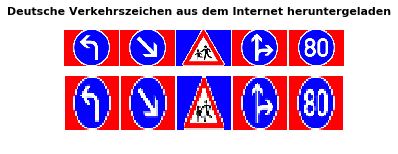

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import csv
%matplotlib inline

#Read the provided signnames.csv for image labels
signnames = []

with open('signnames.csv', 'r') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        signnames += [row[1]]
   
fnames = np.array(['1-TL-p.png', '2-KR-p.png', '3-CC-p.png', '4-GSR-p.png', '5-80-p.png'])
numfigs = len(fnames)
numrows = 2
testfigs = []
resized_testfigs = []

fig = plt.figure(figsize=(numfigs,numrows))
gs1 = gridspec.GridSpec(numrows,numfigs)
gs1.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 


for j in range(numfigs):
    testfigs.append(cv2.cvtColor(cv2.imread(fnames[j],1), cv2.COLOR_BGR2RGB))
    resized_testfigs.append(cv2.resize(testfigs[-1], (32,32), interpolation = cv2.INTER_CUBIC))
    ax = plt.subplot(gs1[j])
    plt.imshow(testfigs[-1])
    plt.axis('off')
    ax = plt.subplot(gs1[numfigs+j])
    plt.imshow(resized_testfigs[-1])
    plt.axis('off')

#Just for fun 
#fig.suptitle('German Traffic Signs Downloaded From the Internet', fontsize=11, fontweight='bold')
fig.suptitle('Deutsche Verkehrszeichen aus dem Internet heruntergeladen', fontsize=11, fontweight='bold')


In [20]:
#print  ("Tensorflow -v', tf.__version__)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))  
    predicted_logits = sess.run(logits, feed_dict={x: resized_testfigs})
    predicted_labels = np.argmax(predicted_logits, axis=1)
    print (predicted_labels)
    for i in range(len(testfigs)):
        print("{0} - Prediction: {1}".format(fnames[i],signnames[predicted_labels[i]]))

INFO:tensorflow:Restoring parameters from .\p2-final4.ckpt
[33 38 11 36 40]
1-TL-p.png - Prediction: End of all speed and passing limits
2-KR-p.png - Prediction: Go straight or left
3-CC-p.png - Prediction: No passing for vehicles over 3.5 metric tons
4-GSR-p.png - Prediction: Ahead only
5-80-p.png - Prediction: Keep left


In [16]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, 64):
        batch_x, batch_y = X_data[offset:offset+64], y_data[offset:offset+64]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

saver = tf.train.Saver()

#resized_figs = preprocess(resized_figs)
y_test = [34, 38, 28, 36, 5]

with tf.Session() as sess:
    #saver = tf.train.import_meta_graph ('simplenet.met')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_acc = evaluate(resized_testfigs, y_test)
    print("New Imgs Test Accuracy = {:.3f}".format(test_acc))
   
    
#   sess.run(accuracy_operation, feed_dict={x: X_new, y: batch_y})
#   with tf.Session() as sess:
#   saver.restore(sess, tf.train.latest_checkpoint('.'))
#   test_accuracy = evaluate(X_test, y_test)
#   print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\p2-final4.ckpt
New Imgs Test Accuracy = 0.600


[[  5.25094569e-01   2.44353786e-01   1.41042918e-01   8.84098336e-02
    6.99087861e-04]
 [  1.00000000e+00   6.20655527e-10   1.84339060e-15   1.84292984e-19
    4.46177542e-33]
 [  9.33456123e-01   6.57192916e-02   7.26317230e-04   6.73705144e-05
    1.23426535e-05]
 [  1.00000000e+00   4.30780121e-20   2.60777094e-23   1.28891651e-25
    1.09222221e-31]
 [  4.99695241e-01   4.87752885e-01   3.66380601e-03   2.61092721e-03
    2.22859252e-03]] [[33 40 34 35 12]
 [38 15 13 40 12]
 [11 27 26 37  8]
 [36 35 40 38 12]
 [40 11 16 42 19]]


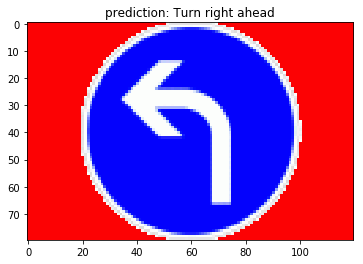

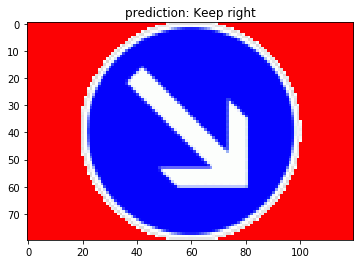

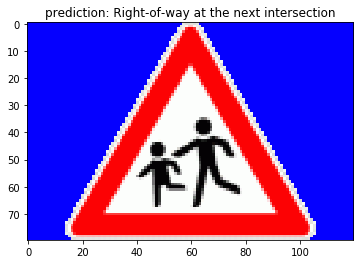

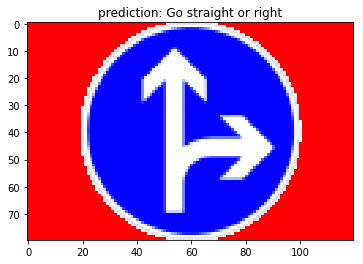

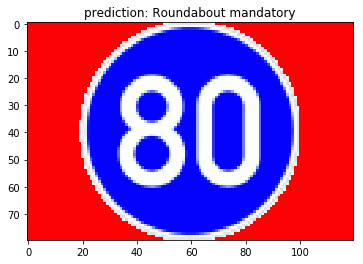

In [21]:
#Check the quality of predictions 
for j in range(len(testfigs)):
    plt.figure()
    plt.imshow(testfigs[j])
    plt.title('prediction: ' + signnames[predicted_labels[j]+1])
    

#Softmax probabilities check    
with tf.Session() as sess:
    softmax = tf.nn.softmax(predicted_logits)
    top5 = sess.run(tf.nn.top_k(softmax, k=5))
    print (top5[0], top5[1])
    #for i in range(len(testfigs)):
    #    print("{0}:".format(fnames[i]))
    #    for j in range(5):
    #        print("{:s}: {:.2f}%".format(signnames[top5[1][j][i]], top5[0][j][i]*100))
    #    print()

In [18]:
#NOT USED
assert False
# a la Arthur Juliani - NW

def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[32,32, 3],order='F'),keep_prob:1.0})
    plotNNFilter(units)
        
imageToUse = X_train[0]
plt.imshow(np.reshape(imageToUse,[32,32,3]), interpolation="nearest", cmap="gray")

sess.run(conv1)
getActivations(conv1,imageToUse)


AssertionError: 